In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import shutil
import glob
import matplotlib.pyplot as plt
import cv2
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
from numpy import loadtxt
from tensorflow.keras.models import load_model

In [1]:
#importing tensorflow stuffs
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Dropout,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
#create the directory structure
base_dir='F:/4th year project/flower_cnn/dataset/flowers'

In [3]:
#classes or labels
classes=['daisy','dandelion','rose','sunflower','tulip']

In [6]:
#for opening images
for x in classes:
    images=[]
    flower_dir=os.path.join(base_dir,x)
    print(flower_dir)
    for img in glob.glob(flower_dir + '/*.jpg'):#parameter should be string pattern
        images.append(img)
    print("{} : {} images".format(x,len(images)))
    
    #deviding the images into trainning and testing set(80% of then are in trainning set and remaining are in validation set)
    
    num_train=int(len(images)*0.8)
    train_set,val_set=images[:num_train],images[num_train:]
    
    #moving the images to train set
    
    for t in train_set:
        if not os.path.exists(os.path.join(base_dir,'train',x)):
            os.makedirs(os.path.join(base_dir,'train',x))
        shutil.move(t,os.path.join(base_dir,'train',x))
    
    #moving the images to validation set
    
    for val in val_set:
        if not os.path.exists(os.path.join(base_dir,'validation',x)):
            os.makedirs(os.path.join(base_dir,'validation',x))
        shutil.move(val,os.path.join(base_dir,'validation',x))

F:/4th year project/flower_cnn/dataset/flowers\daisy
daisy : 0 images
F:/4th year project/flower_cnn/dataset/flowers\dandelion
dandelion : 0 images
F:/4th year project/flower_cnn/dataset/flowers\rose
rose : 0 images
F:/4th year project/flower_cnn/dataset/flowers\sunflower
sunflower : 0 images
F:/4th year project/flower_cnn/dataset/flowers\tulip
tulip : 0 images


In [7]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

In [8]:
batch_size=100
img_shape=150

In [9]:
#Image augmentation


#1.read the images from the disk using flow_from_directory
#2.decode the contents of these images and convert it into proper grid format as per their RGB content
#3.convert them into floating point tensors
#4.rescale,rotation,width_shift etc are done on the images


img_gen_train=ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
)

train_data_gen=img_gen_train.flow_from_directory(
    batch_size=batch_size,#no of images to be yeilded from the generator per batch
    directory=train_dir,
    shuffle=True,
    target_size=(img_shape,img_shape),
    class_mode='sparse'#return integer labels like 1 for daisy,2 for dandelion,3 for rose etc
)

Found 3457 images belonging to 5 classes.


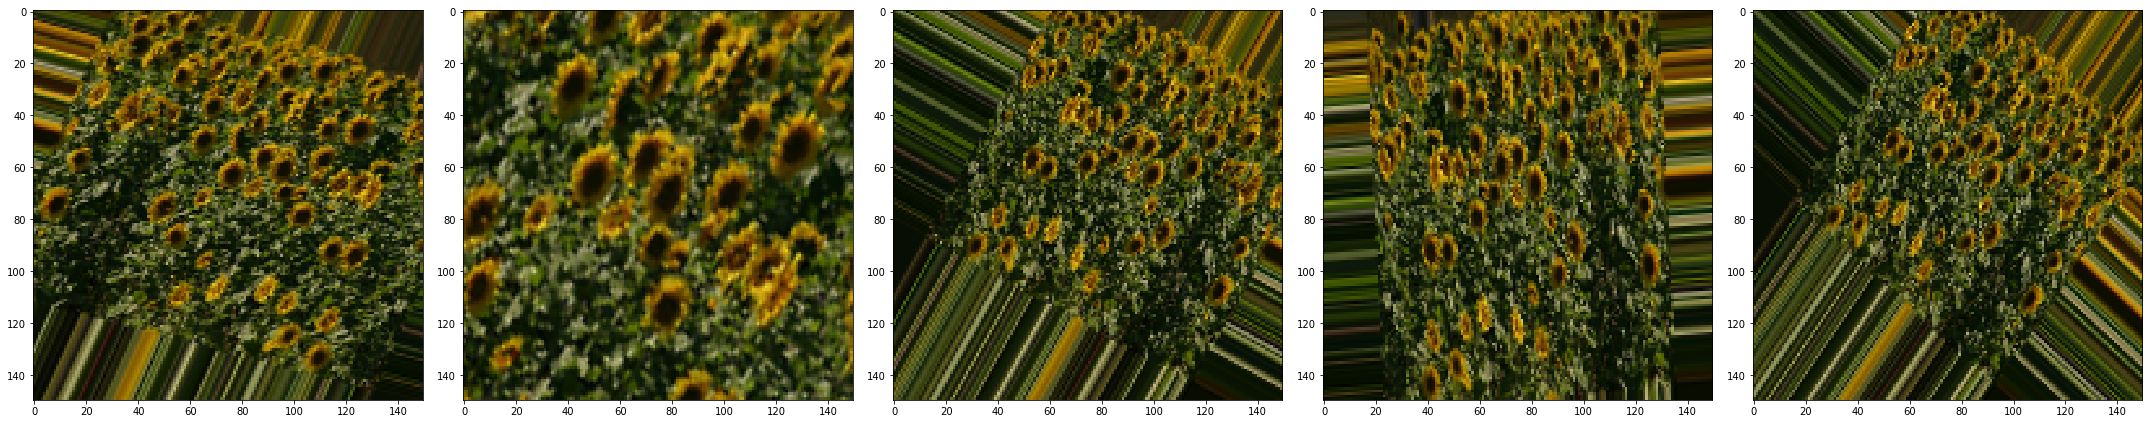

In [21]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,5 , figsize=(30,30))
    
    #for 5 images 5 different axes will be there by which we can plot the images
    
    print(axes)
    axes = axes.flatten()
    print(axes)
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

#show the augmented images
augmented_images=[]
for i in range(5):
    augmented_images.append(train_data_gen[0][0][0])
plotImages(augmented_images)
    
    

In [10]:
#model creation

model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_shape,img_shape, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

In [4]:
model.summary()
#formula for param of conv2d
#((filter_width*filter_height)*input_channel+1)*no of filters
#for 1st conv layer:-(3*(3*3)+1)*16=448
#

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20736)             0         
__________

In [11]:
#compile the model

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
#image data generator for validation set

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(img_shape, img_shape),
                                                 class_mode='sparse')

Found 866 images belonging to 5 classes.


In [13]:
#trainning of images

epochs = 90

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Epoch 1/90
35/35 [==============================] - 320s 9s/step - loss: 1.9038 - acc: 0.2682 - val_loss: 1.3059 - val_acc: 0.4249
Epoch 2/90
35/35 [==============================] - 148s 4s/step - loss: 1.2439 - acc: 0.4510 - val_loss: 1.1403 - val_acc: 0.5069
Epoch 3/90
35/35 [==============================] - 137s 4s/step - loss: 1.1373 - acc: 0.5366 - val_loss: 1.1525 - val_acc: 0.5185
Epoch 4/90
35/35 [==============================] - 138s 4s/step - loss: 1.0951 - acc: 0.5577 - val_loss: 0.9989 - val_acc: 0.6178
Epoch 5/90
35/35 [==============================] - 139s 4s/step - loss: 1.0209 - acc: 0.6005 - val_loss: 0.9272 - val_acc: 0.6478
Epoch 6/90
35/35 [==============================] - 138s 4s/step - loss: 0.9974 - acc: 0.6075 - val_loss: 0.8675 - val_acc: 0.6767
Epoch 7/90
35/35 [==============================] - 135s 4s/step - loss: 0.9739 - acc: 0.6124 - val_loss: 0.9273 - val_acc: 0.6420
Epoch 8/90
35/35 [==============================] - 137s 4s/step - loss: 0.9527 - a

Epoch 40/90
35/35 [==============================] - 140s 4s/step - loss: 0.5636 - acc: 0.7828 - val_loss: 0.6636 - val_acc: 0.7564
Epoch 41/90
35/35 [==============================] - 135s 4s/step - loss: 0.5712 - acc: 0.7796 - val_loss: 0.6485 - val_acc: 0.7575
Epoch 42/90
35/35 [==============================] - 134s 4s/step - loss: 0.5496 - acc: 0.7946 - val_loss: 0.6448 - val_acc: 0.7702
Epoch 43/90
35/35 [==============================] - 134s 4s/step - loss: 0.5675 - acc: 0.7848 - val_loss: 0.6621 - val_acc: 0.7448
Epoch 44/90
35/35 [==============================] - 135s 4s/step - loss: 0.5620 - acc: 0.7833 - val_loss: 0.6356 - val_acc: 0.7540
Epoch 45/90
35/35 [==============================] - 135s 4s/step - loss: 0.5404 - acc: 0.7946 - val_loss: 0.6360 - val_acc: 0.7610
Epoch 46/90
35/35 [==============================] - 134s 4s/step - loss: 0.5631 - acc: 0.7816 - val_loss: 0.7038 - val_acc: 0.7333
Epoch 47/90
35/35 [==============================] - 133s 4s/step - loss: 0.

Epoch 79/90
35/35 [==============================] - 134s 4s/step - loss: 0.3947 - acc: 0.8510 - val_loss: 0.7169 - val_acc: 0.7702
Epoch 80/90
35/35 [==============================] - 134s 4s/step - loss: 0.4131 - acc: 0.8464 - val_loss: 0.6723 - val_acc: 0.7771
Epoch 81/90
35/35 [==============================] - 134s 4s/step - loss: 0.4162 - acc: 0.8516 - val_loss: 0.7059 - val_acc: 0.7725
Epoch 82/90
35/35 [==============================] - 134s 4s/step - loss: 0.3860 - acc: 0.8525 - val_loss: 0.7320 - val_acc: 0.7413
Epoch 83/90
35/35 [==============================] - 134s 4s/step - loss: 0.3800 - acc: 0.8559 - val_loss: 0.6954 - val_acc: 0.7656
Epoch 84/90
35/35 [==============================] - 134s 4s/step - loss: 0.3903 - acc: 0.8507 - val_loss: 0.7298 - val_acc: 0.7748
Epoch 85/90
35/35 [==============================] - 135s 4s/step - loss: 0.4091 - acc: 0.8461 - val_loss: 0.7484 - val_acc: 0.7529
Epoch 86/90
35/35 [==============================] - 134s 4s/step - loss: 0.

In [52]:
model.save('F:/4th year project/flower_cnn/dataset/flowers/model_flower1.h5')

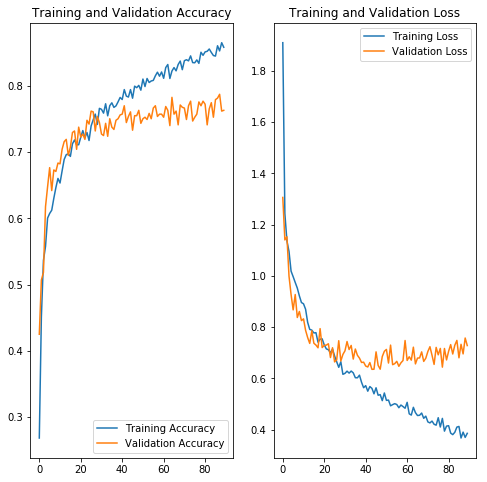

In [14]:
#plotting the aquracy and loss graph

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
#saving this plot

plt.savefig("F:/4th year project/flower_cnn/dataset/flowers/plot1.jpg")

<Figure size 432x288 with 0 Axes>

In [17]:
model.save('F:/4th year project/flower_cnn/dataset/flowers/model_flower2(76%acc).h5')

In [4]:
model=load_model('F:/4th year project/flower_cnn/dataset/flowers/model_flower1.h5')

In [5]:
def predict_one_image(img, model):
    img = cv2.resize(img, (150, 150), interpolation = cv2.INTER_CUBIC)
    img = np.reshape(img, (1, 150, 150, 3))
    img = img/255.
    pred = model.predict(img)
    class_num = np.argmax(pred)
    return class_num, np.max(pred)

rose 100%


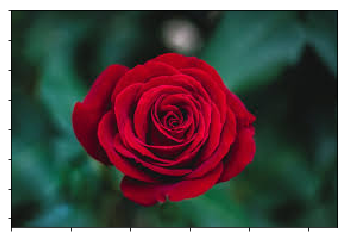

In [9]:
test_img = cv2.imread('C:/Users/ARPAN/Downloads/pictures/rose.jpg')
pred, probability = predict_one_image(test_img, model)
print('%s %d%%' % (classes[pred], round(probability, 2) * 100))
_, ax = plt.subplots(1)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid('off')
plt.show()